In [18]:
import numpy as np
import pandas as pd
from collections import defaultdict
import string

In [19]:
# read data
df = pd.read_csv('train.csv')
text = df['text']

In [313]:
# function to parse text
def split_text(sentence):
    punctuation = set([".",",","?","!","-", ":", ";"])
    r = ''.join([c for c in sentence.lower()])
    ls = ''
    for c in r:
        if c in punctuation:
            ls+= ' ' + c + ' '
        else:
            ls+=c
    return ls.split()

In [314]:
# find top 5000 words
wordCount = defaultdict(int)
avglen = 0
for d in text:
    for w in split_text(d):
        wordCount[w] += 1
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:5000]]
wordId = dict(zip(words, range(len(words))))
idToWord = dict(zip(range(len(words)),words))
wordSet = set(words)

In [315]:
# process data
parsed_text = []
for d in text:
    split = split_text(d)
    parsed_text.append([c for c in split if c in wordSet])

In [316]:
# read in glove model
def loadGloveModel(gloveFile):
    f = open(gloveFile,'r', encoding='utf-8')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model
glove = loadGloveModel('glove50d.txt')

Done. 400000  words loaded!


In [317]:
# some constants to set
seq_length = 10
embedding_length = 50
vocab_len = 5000
learning_rate = 0.01
# this is the loss function for the network
criterion = nn.CrossEntropyLoss()
num_layers = 3

In [318]:
# some helpful torch functions
import torch
# return a tensor glove rep of the given word
def word_tensor(word):
    tensor = []
    word = word.lower()
    if word in glove:
        tensor = torch.from_numpy(glove[word])
    return tensor
# return a tensor representation of a sentence
def sentence_tensor(sentence):
    tensor = torch.zeros(len(sentence), 1, 50)
    for li, word in enumerate(sentence):
        if word in glove:
            tensor[li][0] = word_tensor(word)
    return tensor
# given an output vector return the highest probability word
def wordFromOutput(output):
    top_n, top_i = output.topk(1)
    word = top_i[0].item()
    return idToWord[word]
# samples the output vector for a word
def sample_output(output):
    top_n, top_i = output.topk(5)
    i = random.randint(0,4)
    print(output)
    word = top_i[0][0][i].item()
    return idToWord[word]
def target_tensor(word):
    tensor = torch.zeros(1, 5000)
    torch[0][wordId[word]] = 1
# formats a training example into a tensor of sequence length glove vectors
def parseTrainingExample(i):
    target = train_target[i]
    sequence = train_sentences[i]
    sequence_tensor = sentence_tensor(sequence)
    target_tensor = torch.tensor([wordId[target]], dtype=torch.long)
    return sequence, target, sequence_tensor, target_tensor

In [319]:
# helper function to parse new sentences (make sure no words not in the model are used)
def parse_text(sentence):
    split = split_text(sentence)
    return [c for c in split if c in wordSet]

In [320]:
#some pre-processing to break the words up into a training matrix with sequence lengths of seq_length
train_sentences = []
#the next word in the sequence (word to be predicted)
train_target = []
for t in parsed_text: 
    for i in range(len(t)-seq_length):
        sequence = []
        for j in range(seq_length):
            sequence.append(t[i+j])
        # add the seq_length word sequence to the training examples
        train_sentences.append(sequence)
        # add the next word after sequence to targets for prediction
        train_target.append(t[i+seq_length])

In [338]:
target_dict = {}
for index,item in enumerate(train_target):
    if item not in target_dict:
        target_dict[item] = []
    target_dict[item].append(index)

In [341]:
def select_random_example():
    i = random.randint(0,5000-1)
    if idToWord[i] in target_dict:
        examples = target_dict[idToWord[i]]
    else:
        return select_random_example()
    i = random.randint(0,len(examples)-1)
    return examples[i]

In [350]:
# define the model
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, dropout=.2,num_layers=num_layers)
        self.l2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        lstm_out, hidden = self.lstm(input.view(1,1,-1), hidden)
        output = self.l2o(lstm_out)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(num_layers, 1, self.hidden_size),torch.zeros(num_layers, 1, self.hidden_size))
rnn = RNN(embedding_length, embedding_length, vocab_len, num_layers)

In [351]:
# function to run one iteration of the network 
# text_tensor is a tensor representation of the sequence length
# hidden is a tensor representation of the hidden state of the lstm
# prediction_tensor is a length 1 tensor that conatins the word id of the target word
def train(text_tensor, prediction_tensor):
    #initialize the hidden state (zero it)
    hidden = rnn.initHidden()
    # zero the gradient
    rnn.zero_grad()

    # run the network over the sequence
    for i in range(seq_length):
        output, hidden = rnn(text_tensor[i], hidden)

    # compute the loss and calculate auto-grad
    loss = criterion(output.view(1,-1), prediction_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, hidden, loss.item()

In [356]:
import time
import math
import random

# some constants for the training step
n_iters = len(train_sentences)
print_every = 500
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# get the time since last print
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1,n_iters):
    if iter % 2 == 0:
        sequence, target, sequence_tensor, target_tensor = parseTrainingExample(select_random_example())
    else:
        sequence, target, sequence_tensor, target_tensor = parseTrainingExample(iter)
    output, hidden, loss = train(sequence_tensor, target_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess = wordFromOutput(output)
        correct = '✓' if guess == target else '✗ (%s)' % target
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, sequence, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 0% (0m 10s) 9.3727 ['may', 'this', 'be', 'the', 'last', 'misfortune', 'that', 'you', 'will', 'ever'] / of ✗ (suffer)
1000 0% (0m 19s) 8.3133 ['widely', 'extended', ',', 'and', 'in', 'full', 'view', 'the', 'and', 'blackened'] / , ✗ (tongue)
1500 0% (0m 29s) 8.0892 ['the', 'very', 'suggestion', 'of', 'such', 'a', 'possibility', 'is', 'considered', 'an'] / the ✗ (insult)
2000 0% (0m 39s) 9.5667 ['me', '"', 'cannot', 'tell', 'from', '.', '"', '"and', 'yet', 'some'] / of ✗ (fools)
2500 0% (0m 48s) 8.1543 ['late', 'rough', 'as', 'an', 'wild', 'in', 'america', ',', 'as', 'the'] / , ✗ (wind)
3000 0% (0m 58s) 8.6134 ['possessed', 'of', 'was', 'one', 'of', 'those', 'which', 'resemble', 'a', 'large'] / . ✗ (box)
3500 1% (1m 8s) 9.2074 ['so', 'throughout', 'with', 'the', 'yellow', ',', 'the', 'white', ',', 'the'] / . ✗ (purple)
4000 1% (1m 17s) 8.3660 [',', 'when', 'a', 'great', 'gale', 'drove', 'the', 'waters', 'of', 'the'] / , ✗ (bay)
4500 1% (1m 27s) 8.7206 [',', 'while', 'the', 'narrow', '

35500 10% (11m 50s) 9.1516 ['and', ',', 'with', 'fury', ',', 'down', 'the', 'long', 'avenue', 'which'] / , ✗ (extended)
36000 10% (12m 1s) 9.0957 ['smell', 'of', ',', 'and', 'grow', 'faint', 'at', 'a', 'of', 'unusually'] / the ✗ (cool)
36500 10% (12m 11s) 8.9068 ['once', 'fell', 'into', 'the', 'rear', ',', 'and', 'now', ',', 'with'] / the ✗ (hearts)
37000 10% (12m 22s) 8.6646 [';', 'it', 'was', 'in', 'the', 'latter', 'city', 'that', 'his', 'great'] / . ✗ (discovery)
37500 10% (12m 33s) 8.4591 ['must', ',', 'i', 'saw', ',', 'trust', 'to', 'such', 'barriers', 'to'] / . ✗ (shield)
38000 11% (12m 43s) 8.7910 ['happened', 'to', 'enter', 'the', 'cottage', ',', 'their', 'harsh', 'manners', 'and'] / , ✗ (rude)
38500 11% (12m 54s) 8.8065 ['that', 'had', 'no', 'need', 'of', 'a', 'charm', ',', 'by', 'thought'] / the ✗ (supplied)
39000 11% (13m 4s) 8.8270 [',', 'and', 'the', 'second', 'supposed', 'elopement', ',', 'is', 'a', 'few'] / the ✗ (months)
39500 11% (13m 14s) 8.9642 ['express', 'my', ';',

69500 20% (24m 12s) 8.5887 ['either', 'by', 'the', 'seats', 'of', 'the', 'company', ',', 'or', 'by'] / the ✗ (turning)
70000 20% (24m 23s) 8.8864 ['you', 'of', 'exile', 'and', ',', 'while', 'a', ',', 'a', 'gold'] / , ✗ (tissue)
70500 20% (24m 33s) 9.0970 ['the', 'of', 'victory', ',', 'he', ',', 'in', 'some', 'manner', ','] / , ✗ (contrived)
71000 20% (24m 43s) 8.9138 ['cried', ';', '"how', 'i', 'enjoy', 'existence', 'but', 'you', ',', 'my'] / the ✗ (dear)
71500 20% (24m 54s) 9.0160 ['upon', 'me', ',', 'and', 'the', 'ugly', 'of', 'existence', 'began', 'to'] / . ✗ (drive)
72000 20% (25m 5s) 8.6944 [';', 'and', 'the', 'deep', 'waters', ',', 'full', 'of', 'the', 'one'] / , ✗ (primal)
72500 21% (25m 17s) 9.0627 ['in', 'the', 'of', 'the', 'flower', ',', 'he', 'recognized', 'the', 'most'] / , ✗ (direct)
73000 21% (25m 30s) 9.3653 ['.', '"', '"by', 'yourself', 'what', 'do', 'you', 'mean', '?', '"'] / , ✗ ("why)
73500 21% (25m 42s) 9.0173 ['when', 'it', 'into', 'sight', 'and', 'its', 'green', '

103500 30% (37m 19s) 8.8590 ['not', ',', 'for', 'some', 'weeks', ',', ',', 'or', 'otherwise', 'violently'] / the ✗ (ill)
104000 30% (37m 31s) 9.1366 ['he', 'had', 'said', ',', 'the', 'type', 'of', 'all', 'that', 'was'] / , ✗ (gallant)
104500 30% (37m 43s) 8.9765 ['by', 'way', 'of', 'best', 'any', 'portion', 'of', 'that', 'world', 'from'] / the ✗ (perceiving)
105000 30% (37m 56s) 8.9001 ['broken', 'a', 'with', 'such', 'of', 'tradition', 'as', 's', '.', 'and'] / , ✗ (thomas)
105500 30% (38m 8s) 9.3182 ['beyond', 'the', ',', 'or', 'in', 'the', 'black', 'of', 'that', 'ultimate'] / , ✗ (void)
106000 30% (38m 20s) 9.0485 ['he', 'at', 'last', 'realised', 'bore', 'such', 'a', 'shocking', ',', 'mocking'] / the ✗ (resemblance)
106500 30% (38m 33s) 9.0863 ['one', 'half', 'of', 'his', 'fortune', ',', 'as', 'of', 'utterly', 'whole'] / , ✗ (troops)
107000 31% (38m 45s) 8.8291 ['bringing', 'into', 'practice', 'relations', 'of', 'size', ',', 'proportion', ',', 'and'] / the ✗ (color)
107500 31% (38m 57

137500 39% (49m 35s) 9.4485 ['lit', 'the', 'giant', 'twisted', 'trees', 'and', 'the', 'of', 'the', 'buried'] / , ✗ (temples)
138000 40% (49m 45s) 8.3668 ['protect', 'her', 'from', 'the', 'agonies', 'of', 'passion', ',', 'and', 'the'] / the ✗ (despair)
138500 40% (49m 55s) 8.5095 ['for', 'the', 'i', 'it', 'just', 'so', 'much', 'that', 'a', 'single'] / the ✗ (thin)
139000 40% (50m 5s) 9.3639 ['final', 'dissolution', 'from', 'which', 'there', 'could', 'be', 'no', 'return', ','] / , ✗ (screamed)
139500 40% (50m 15s) 8.9119 ['inches', 'in', 'diameter', ',', 'and', 'fitted', 'with', 'a', 'brass', 'rim'] / , ✗ (adapted)
140000 40% (50m 25s) 9.3340 ['i', 'found', 'it', 'impossible', 'to', 'comprehend', ',', 'i', 'ventured', 'to'] / , ✗ (suggest)
140500 40% (50m 35s) 8.6897 ['benevolent', 'action', 'to', 'rescue', 'the', 'sufferer', ',', 'whether', 'human', 'or'] / the ✗ (brute)
141000 40% (50m 46s) 8.9556 ['of', 'october', ',', 'the', 'of', 'the', 'of', 'lord', 'to', 'general'] / the ✗ (washin

170500 49% (60m 38s) 9.3160 ['with', 'one', 'only', 'exception', ',', 'that', 'of', 'the', 'of', 'chief'] / , ✗ (magistrate)
171000 49% (60m 48s) 8.7765 ['increased', 'my', 'fury', ',', 'as', 'the', 'beating', 'of', 'a', 'the'] / the ✗ (soldier)
171500 49% (60m 59s) 9.0027 ['fell', 'from', 'his', 'arms', 'on', 'the', 'ground', ',', 'and', 'he'] / the ✗ (bowed)
172000 49% (61m 9s) 8.9218 ['otherwise', 'quite', 'restored', 'to', 'health', ',', 'the', 'sight', 'of', 'a'] / , ✗ (chemical)
172500 50% (61m 20s) 8.6909 ['the', 'talents', 'and', 'courage', 'of', 'raymond', 'were', 'highly', 'among', 'the'] / , ✗ (greeks)
173000 50% (61m 31s) 9.8355 [',', 'that', 'happy', 'is', 'the', 'tomb', 'where', 'no', 'wizard', 'hath'] / the ✗ (lain)
173500 50% (61m 41s) 9.5856 ['windsor', ';', 'and', 'she', 'and', 'my', 'two', 'lovely', 'were', 'perpetual'] / of ✗ (sources)
174000 50% (61m 51s) 8.8034 ['place', 'was', 'rare', 'in', 'its', 'imaginative', ',', 'and', 'worthy', 'of'] / the ✗ (note)
174500 5

204000 59% (71m 56s) 9.6449 ['of', 'determined', 'settled', 'upon', 'his', 'countenance', ',', 'as', 'he', 'gave'] / , ✗ (orders)
204500 59% (72m 7s) 9.4427 ['"', 'replied', 'dupin', ';', '"and', 'the', 'prefect', 'and', 'his', 'cohort'] / . ✗ (fail)
205000 59% (72m 18s) 8.9297 ['that', 'triumph', 'there', 'came', 'to', 'me', 'the', 'greatest', 'of', 'all'] / , ✗ (horrors)
205500 59% (72m 29s) 9.2482 ['raise', 'that', 'in', 'you', 'which', 'is', 'death', 'to', 'me', ','] / , ✗ (anger)
206000 59% (72m 40s) 9.2489 [';', 'but', 'birch', 'in', 'those', 'days', 'was', ',', 'and', 'was'] / the ✗ (concerned)
206500 59% (72m 51s) 8.8065 [',', 'and', 'in', 'cities', 'blow', 'wild', 'learned', 'from', 'the', 'elder'] / of ✗ (ones)
207000 60% (73m 2s) 8.8688 [',', 'even', 'through', 'the', 'gloom', 'of', 'the', 'apartment', ',', 'became'] / the ✗ (distinctly)
207500 60% (73m 13s) 8.7936 ['you', 'will', 'smile', 'at', 'my', ',', 'but', 'i', 'will', 'a'] / of ✗ (secret)
208000 60% (73m 23s) 8.7130 

237500 68% (83m 34s) 9.2117 ['the', 'altered', 'edifice', 'in', 'which', 'i', 'now', 'stood', ';', 'i'] / the ✗ (recognised)
238000 69% (83m 44s) 8.9831 ['never', 'kinder', 'to', 'the', 'old', 'man', 'than', 'during', 'the', 'whole'] / of ✗ (week)
238500 69% (83m 54s) 8.5330 ['brain', ';', 'she', 'rushed', 'to', 'the', 'window', ';', 'and', 'a'] / of ✗ (flash)
239000 69% (84m 4s) 8.8329 ['echo', 'with', 'the', 'voice', 'which', 'filled', 'each', 'heart', ',', 'the'] / of ✗ (newspapers)
239500 69% (84m 15s) 8.7788 ['and', 'therefore', ',', 'although', 'of', ',', 'would', 'form', 'a', 'strong'] / of ✗ (band)
240000 69% (84m 25s) 9.1993 ['could', 'not', 'however', 'at', 'that', 'time', 'feel', 'remorse', ',', 'for'] / the ✗ (methought)
240500 69% (84m 35s) 9.4689 ['despite', 'much', 'with', 'the', 'papers', 'and', 'of', 'my', 'uncle', ','] / , ✗ (failed)
241000 69% (84m 45s) 8.7799 ['my', 'rapidly', 'advanced', ',', 'yet', 'this', 'was', 'the', 'thought', 'that'] / the ✗ (haunted)
241500 

KeyboardInterrupt: 

In [ ]:
torch.save(rnn.state_dict(), 'rnn_top5000')

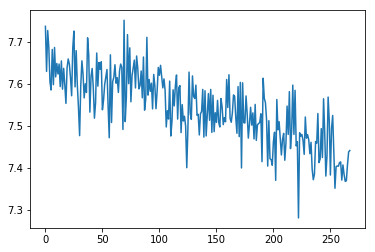

In [357]:
#plot the avg loss over training time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [358]:
# test run
# Just return an output given a line
def evaluate(sequence_tensor):
    hidden = rnn.initHidden()
    output = []
    for i in range(seq_length):
        output, hidden = rnn(sequence_tensor[i], hidden)
    return output

input_sentence = ['The', 'details', 'were', 'examined', 'and', 'it', 'was', 'found', 'that', 'the']
for i in range(100):
    with torch.no_grad():
        output = evaluate(sentence_tensor(input_sentence[i:i+seq_length]))
    input_sentence.append(sample_output(output))
    

tensor([[[ 4.0901e+00,  2.3302e+00,  4.1455e+00,  ...,  1.4132e-01,
           2.7443e-01, -2.2776e-01]]])
tensor([[[ 4.4337,  2.7561,  4.7464,  ...,  0.1874,  0.2401, -0.3081]]])
tensor([[[ 4.8506,  3.4588,  5.0483,  ...,  0.1518,  0.1880, -0.2797]]])
tensor([[[ 5.1202,  5.1387,  5.1671,  ...,  0.0753, -0.0126, -0.3187]]])
tensor([[[ 7.0497,  5.9511,  6.4760,  ..., -0.2045, -0.5471, -0.0685]]])
tensor([[[ 4.7204e+00,  6.5120e+00,  3.3256e+00,  ..., -3.7056e-01,
          -4.1147e-01,  1.6636e-02]]])
tensor([[[ 4.6835e+00,  2.3527e+00,  4.8842e+00,  ...,  1.3672e-01,
           2.0740e-01, -2.3075e-01]]])
tensor([[[ 6.1497e+00,  5.0089e+00,  6.1133e+00,  ..., -1.1364e-01,
          -2.1701e-01, -2.1091e-01]]])
tensor([[[ 6.6357e+00,  6.1037e+00,  5.5643e+00,  ..., -3.9280e-01,
          -7.0947e-01,  1.0475e-01]]])
tensor([[[ 4.6707,  6.5506,  3.2519,  ..., -0.3886, -0.4422,  0.0255]]])
tensor([[[ 4.1110e+00,  2.5849e+00,  4.1542e+00,  ...,  1.2310e-01,
           2.1896e-01, -1.9983e-

tensor([[[ 6.1715,  5.6429,  5.2562,  ..., -0.3317, -0.5731,  0.0617]]])


In [359]:
input_sentence

['The',
 'details',
 'were',
 'examined',
 'and',
 'it',
 'was',
 'found',
 'that',
 'the',
 'the',
 'the',
 'of',
 ',',
 'and',
 'my',
 ',',
 ',',
 'and',
 'a',
 ',',
 '.',
 'the',
 'of',
 ',',
 'of',
 'the',
 'a',
 'the',
 ',',
 '.',
 ',',
 'and',
 'a',
 'of',
 '.',
 'of',
 'the',
 ',',
 'of',
 'his',
 '.',
 'of',
 '.',
 '.',
 ',',
 'the',
 '.',
 ',',
 'and',
 ',',
 'and',
 'i',
 'to',
 'a',
 'of',
 '.',
 '.',
 ',',
 'and',
 'my',
 '.',
 'the',
 'the',
 'of',
 'the',
 '.',
 ',',
 'and',
 'my',
 ',',
 'to',
 'i',
 'of',
 ',',
 'the',
 'of',
 ',',
 ',',
 'that',
 'i',
 'a',
 'of',
 '.',
 'my',
 '.',
 ',',
 'the',
 'the',
 ',',
 'and',
 'my',
 ',',
 'and',
 'i',
 'of',
 ',',
 '.',
 ',',
 'and',
 'i',
 ',',
 'and',
 'the',
 ',',
 'to',
 'my',
 ',',
 '.',
 '.']